In [37]:
# Importano as bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from  zlib import crc32
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

In [38]:
# lendo o csv
preco_das_casas_df = pd.read_csv("housing.csv")

In [39]:
# Observando o arquivo csv
preco_das_casas_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [40]:
# Informações da tabela
preco_das_casas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [41]:
# Observei que a coluna ocean_proximity é dividido em categorias, quais são essas categorias?
preco_das_casas_df["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [42]:
# preco_das_casas_df.hist(bins=50, figsize= (20,50))
# plt.show()
# Comentário

In [43]:
def dados_de_teste(dados, razao):
    ## Função com 2 retornos
    ## O primeiro: um Serial do Pandas, com os itens do treino da IA
    ## O Segundo   um Serial do Pandas, com os itens não escolhidos para o treinamento, pois serão testados para validar
    # o Algoritmo

    indices_embaralhados = np.random.permutation(len(dados))
    quantidade_de_dados_para_treino = np.trunc(len(dados) * razao)
    itens_do_treino = indices_embaralhados[:quantidade_de_dados_para_treino]
    teste_indices = indices_embaralhados[quantidade_de_dados_para_treino:]
    return dados.iloc[itens_do_treino], dados.iloc[teste_indices]

A Função de cima têm um problema
    toda vez que o código for instanciado, ele gerará novos valores, o que é ruim e cria algoritmos diferentes quando o código for re instanciado

Como resolver isso?
    salvar os dados que serão usados não será o suficiente, pois quando forem introduzidos mais casos de teste, o algoritmo terá de ser rebobinado, odificando, mais uma vez os casos que alimentarão o algoritmo

A Solução: criar uma espéie de "Marcador" que define se um caso é usado para testes ou se é usado para alimentar o algritmo, com a função crc32 da bibliotca zlib

In [44]:
def identificador_de_testes(id_, proporcao_testes) :
    # id_ é um identificador único que marca as células como testes
    # proporcao_testes é a porcentagem(ex.: 0.2 = 20%) que vocÊ quer separar para os testes(ex.: 0.2 = 20%)
    #
    # Retorna uma expressão booleanda(True se a porcentagem de células marcadas forem menores que a proporcao_testes)

    return crc32(np.int64(id_)) & 0xffffffff < proporcao_testes * 2**32


In [45]:
def divide_testes_de_treino_por_id(dados, proporcao_testes, nome_da_coluna):
    # dados = DataFrame com todos os dados
    # proporcao_testes = porcetagem desejada de casas separads para trino
    # nome_da_coluna = o nome da cplluna criada para o identficador
    #
    # 2 retornos
    # linhas selecionadas para treino
    # linhas selecionadas para teste

    ids = dados[nome_da_coluna]
    esta_no_teste = ids.apply(lambda id_: identificador_de_testes(id_, proporcao_testes))

    return dados.loc[~esta_no_teste], dados.loc[esta_no_teste]

Como o Data Frame não tem uma coluna que marque as linhas como treinamento ou teste, é necessário cria-la
    uma solução boa para esse problema é definir a coluna dos indeces como marcadores, da seguinte forma:

In [46]:
casas_com_id = preco_das_casas_df.reset_index()
dados_treino, dados_teste = divide_testes_de_treino_por_id(casas_com_id, 0.2, "index")

O Scikitlear já possui uma função que faz isso, que é:
    from sklear.model_selection import train_test_split
    Parâmetros: 
    train_test_split(DataFrame, test_size = 0.2, random_state = 42)
        random_state = é uma seed, se setar uma seed como um número qualquer, os selecionados para teste e treino serão sempre os mesmos

In [47]:
dados_treino, dados_teste = train_test_split(preco_das_casas_df, test_size= 0.2, random_state=42)

Geralmente, é necessário dividir os dados em grupos antes de escolher (a mesma porcentagem) de amostras de cada grupo, como por exmplo, divir o grupo entre homens e mulheres e escolher 50% de cada grupo para evitar o VIÉS DE AMOSTRAGEM

como fazer isso? 
    Usando a função cut do Pandas

O exemplo a seguir divide o grupo das casas de acordo com a renda de cada casa, dividindo-as em 5 categorias

<Axes: >

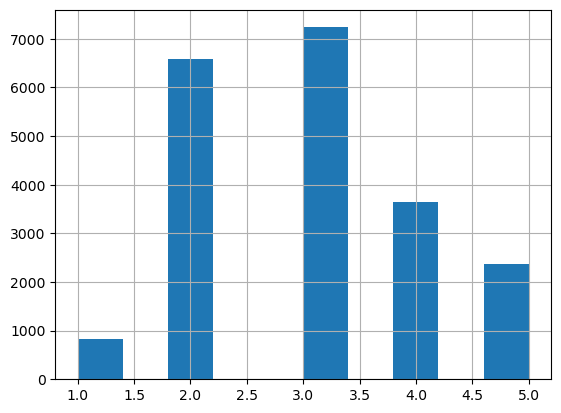

In [48]:
# Função cut do Pandas, recebe os parametros scopo, bins e labels
preco_das_casas_df["income_cat"] = pd.cut(preco_das_casas_df["median_income"], 
                                          bins = [0. , 1.5 , 3. , 4.5 , 6., np.inf],
                                          labels = [1, 2, 3, 4, 5])

preco_das_casas_df["income_cat"].hist() # Criou a coluna income_cat com essas caterias

Agora sim, podemos fazer uma seleção de dados mais bem distribuida, e para isso, usaremos:

From sklear.model_selection import StratifiedShuffleSplit

In [49]:
dividido = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for indice_treino, indice_teste in dividido.split(preco_das_casas_df, preco_das_casas_df["income_cat"]):
    dados_treino = preco_das_casas_df.loc[indice_treino]
    dados_teste  = preco_das_casas_df.loc[indice_teste]

In [50]:
#Removendo a coluna de estratificação, pois não será mais útil para nós
preco_das_casas_df = preco_das_casas_df.drop("income_cat", axis=1)

# Criar uma cópia dos dados para usar por enquanto
copia_df = preco_das_casas_df

<Axes: xlabel='longitude', ylabel='latitude'>

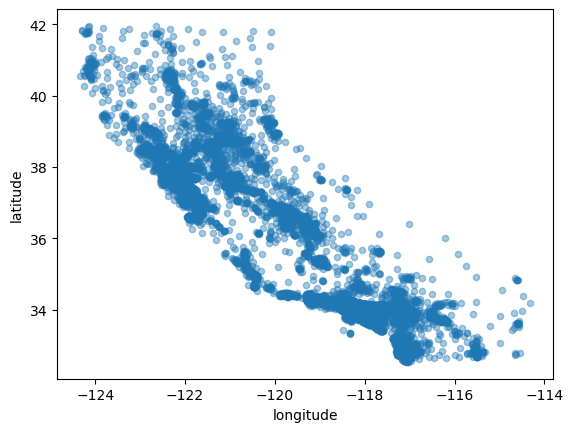

In [56]:
copia_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4) # Vizualização melhor

Muito bom, mas vamos mexer um pouco mais aqui, para deixar mais visivel, faremos o seguinte:

1 - Mudar o tamanho do circulo de acordo com a população da áres

2 - Mudar a cor de acordo com o preço (vermelho = mais caro)

<Axes: xlabel='longitude', ylabel='latitude'>

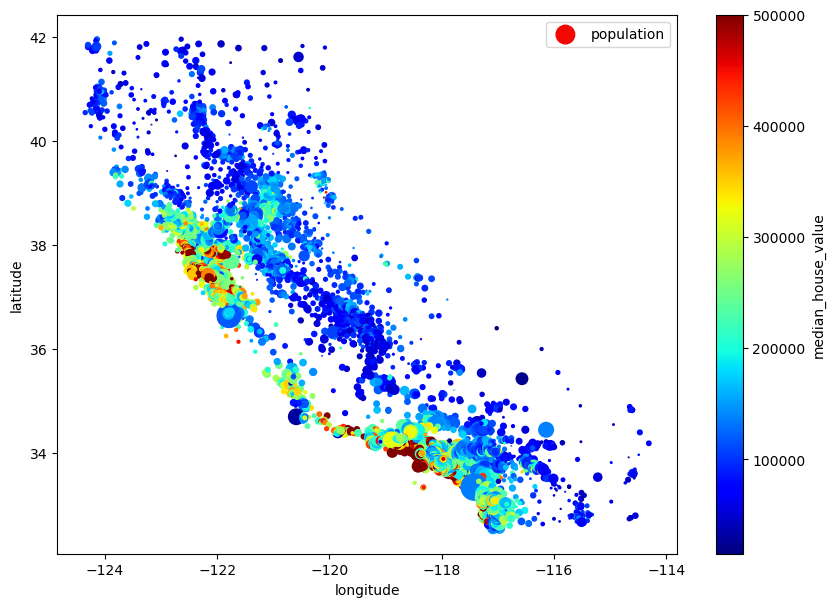

In [63]:
copia_df.plot(kind="scatter", x="longitude", y="latitude",
              s=copia_df["population"] / 100, label="population", figsize=(10, 7), # Tamanho 
              c = "median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)   # Preço média